# Customer Segmentation with K-Means Clustering, February 2018
# Introduction
* In this project, we'll use k-means clustering to perform RFM (Recency, Frequency, Monetary value) cluster analysis on a dataset of customer transactions to discover unique populations that exist in a customer population.
* This is my first attempt with unsupervised learning outside the classroom. 
* This is a real customer dataset from a UK-based retailer, detailing real-world transactions made between December 1st, 2010 and December 9th, 2011. The dataset can be found on the UCI Machine Learning Repository: http://archive.ics.uci.edu/ml/datasets/online+retail

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import warnings
import math

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples, confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict
from sklearn.ensemble import GradientBoostingClassifier

warnings.filterwarnings('ignore')
% matplotlib inline

# Data Preparation

In [2]:
df = pd.read_excel('/Users/jordanbauer/Data Mining Learning/Personal Projects/Clustering/Online Retail.xlsx')
df_original = df.copy()
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


Each observation describes a different product invoiced by a customer, including the quantity ordered, unit price, and time and date of the invoice. Invoices represent orders, cancellations, discounts, etc., any money changing hands.

I don't foresee unit price being useful in our analysis, but we will need the revenue of each invoice. This is easily done, multiplying product quantity by product unit price. We also only need the date, not the time of day, of each transaction.

In [3]:
df['Rev'] = df['Quantity'] * df['UnitPrice']
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'].astype('str').str.split(' ').str.get(0))
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Rev
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850.0,United Kingdom,20.34


In [4]:
def show_missing(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    df = pd.concat([total, percent], axis=1, keys=['Total Missing', '% of Data Missing'])
    df = df[df['Total Missing'] > 0]
    return df

In [5]:
show_missing(df)

,Total Missing,% of Data Missing
CustomerID,135080,0.249267
Description,1454,0.002683


Missing descriptions do not concern us, but missing customer values do. Invoices not associated with a customer have no meaning in our analysis. We'll have to remove those observations.

In [6]:
df['Description'] = df['Description'].fillna('N')
df.dropna(inplace=True)

In [7]:
print('Unique customers:', df['CustomerID'].unique().shape[0])
print('Unique invoices:', df['InvoiceNo'].unique().shape[0])

Unique customers: 4372
Unique invoices: 22190


We have 4,372 individual customers in our customer base responsible for a total of 22,190 invoices. The aim is to cluster our customers based on recency, frequency, and monetary value.
* *Recency*: has it been a long time since we've heard from our customers? The accounts that are generating revenue right now are of the most immediate interest to us. Inversely, the customers who haven't made an order in a long time are in need of attention
* *Frequency*: how often are our customers buying? Our most valuable and reliable customers will be buying on a consistent basis. 
* *Monetary*: on paper, how valuable is each customer? Our dataset records each interaction a customer has had with the company, including orders, returns, cancellations, discounts, etc. We can aggregate the number of total transactions for each customer, as well as sum and mean values for each customer's transactions, to get a glimpse of their net "give and take" impact. *Note: we cannot use standard deviation of customer's transaction values because some customers have recorded just one transaction, yielding a meaningless standard deviation of infinite value.*


# Feature Engineering
We have a date for each individual invoice. We can use this to create features that describe customer activity over time. We can measure time with weeks, months, and days. I'm going to go with weeks, since our dataset only covers a brief period of time, and I think months would demonstrate too little variance while days would introduce too much.

A feature that describes the mean time between customer transactions, their frequency:

In [8]:
def transaction_time_bw(df, customer_id, date_id, invoice_id, time_period='week'):
    temp_dict = {}
    for ID in df[customer_id].unique():
        if time_period == 'week':
            temp = abs(df[df[customer_id] == int(ID)].drop_duplicates(invoice_id)[date_id].dt.week.diff()).dropna()
        elif time_period == 'month':
            temp = abs(df[df[customer_id] == int(ID)].drop_duplicates(invoice_id)[date_id].dt.month.diff()).dropna()
        else:
            temp = abs(df[df[customer_id] == int(ID)].drop_duplicates(Invoice_id)[date_id].diff()).dropna()
        if temp.empty is True:
            temp_dict[int(ID)] = 0
        else:
            temp_dict[int(ID)] = math.floor(temp.astype('str').str.split(' ').str.get(0).astype(np.float64).mean())
    temp_series = pd.Series(data=list(temp_dict.values()), index=list(temp_dict.keys())).sort_index().fillna(0)
    return temp_series

In [9]:
time_deltas = transaction_time_bw(df, 'CustomerID', 'InvoiceDate', 'InvoiceNo')

Features that describe recency, the length of a customer's relationship with the company and the time since their most recent order (we'll pretend that the last date of the dataset, December 9th, 2011, is "today"):

In [10]:
def transaction_time_delta(df, customer_id, date_id, time_period='week'):
    temp_dict = {}
    temp_dict2 = {}
    for ID in df[customer_id].unique():
        temp = df[df[customer_id] == int(ID)][date_id]
        if temp.empty is True:
            continue
        else:
            if time_period == 'week':
                temp_dict[int(ID)] = (df[date_id].max().to_period('W') - temp.max().to_period('W'))
                temp_dict2[int(ID)] = (df[date_id].max().to_period('W') - temp.min().to_period('W'))
            elif time_period == 'month':
                temp_dict[int(ID)] = (df[date_id].max().to_period('M') - temp.max().to_period('M'))
                temp_dict2[int(ID)] = (df[date_id].max().to_period('W') - temp.min().to_period('M'))
            else:
                temp_dict[int(ID)] = (df[date_id].max() - temp.max()).days
                temp_dict2[int(ID)] = (df[date_id].max() - temp.min()).days
    temp_series = pd.Series(data=list(temp_dict.values()), index=list(temp_dict.keys())).sort_index().fillna(0)
    temp_series2 = pd.Series(data=list(temp_dict2.values()), index=list(temp_dict2.keys())).sort_index().fillna(0)
    return (temp_series, temp_series2)

In [11]:
transaction_times = transaction_time_delta(df, 'CustomerID', 'InvoiceDate')
time_since = transaction_times[0]
account_length = transaction_times[1]

# Cluster Analysis

Time to put together our master dataset and begin our analysis. We'll categorize our dataset and summarize multiple observations on a per customer basis, so each customer is one observation. K-means is intended only for numeric data, not categorical, so we'll leave out the country variable for the time being.

In [12]:
master = df.groupby(['CustomerID', 'InvoiceNo'], as_index=False)['Rev'].sum()
master = master.groupby(['CustomerID'])['Rev'].agg(['mean', 'sum', 'count']).sort_index()
master.rename({'mean': 'MeanTransactionNetValue', 'sum': 'NetLifetimeValue', 'count': 'TotalTranscations'}, axis=1, inplace=True)
master['MeanWeeksBwTransactions'] = time_deltas
master['WeeksSinceMostRecent'] = time_since
master['AccountLength'] = account_length
master.head()

,MeanTransactionNetValue,NetLifetimeValue,TotalTranscations,MeanWeeksBwTransactions,WeeksSinceMostRecent,AccountLength
CustomerID,,,,,,
12346.0,0.000000,0.00,2,0,46,46
12347.0,615.714286,4310.00,7,15,0,52
12348.0,449.310000,1797.24,4,26,11,51
12349.0,1757.550000,1757.55,1,0,2,2
12350.0,334.400000,334.40,1,0,44,44


We'll scale our new dataset using a maximum absolute scaler, which sets the maximum value of a vector to 1 and everything else as a relative value less than 1. We'll use this method because there's sparsity in some of our features, lots of zero values that wouldn't place nice with a normal standard scaler. Maximum absolute scaling is best suited for handling sparsity.

In [13]:
master_original = master.copy()
master = pd.DataFrame(MaxAbsScaler().fit_transform(master), index=master.index, columns=master.columns)

Principle Component Analysis (PCA) reduces our number of features by combining multiple feature vectors into individual vectors that explain the most variance in those vectors' data. PCA allows us to reduce the number of features to better enable k-means clustering to produce better clusters, since k-means compares datapoint distances and will do so more successfully in lower-dimensional space.

To choose how many components we want to reduce down to, we can perform PCA multiple times, incrementing the number of components, and plot out the explained variance ratio at each step of the way. We want to choose the point at which the general downward trend begins to level out, as gains in explained variance begin to diminish. This heuristic is called the "elbow method".

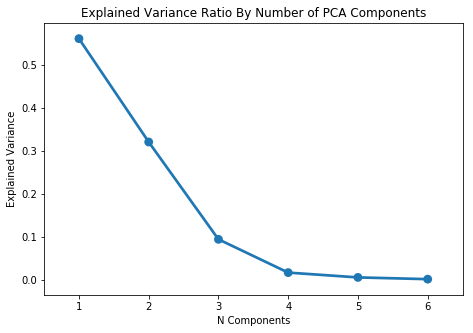

In [14]:
pca = PCA().fit(master)
plt.figure(figsize=(7.5, 5))
plt.title('Explained Variance Ratio By Number of PCA Components')
plt.ylabel('Explained Variance')
plt.xlabel('N Components')
sns.pointplot(x=np.arange(1, master.shape[1] + 1), y=pca.explained_variance_ratio_, lw=1)
plt.show()

Our elbow is at 4 components, so that is the number of PCA features we'll run with. 

Unlike other unsupervised algorithms, like hierarchical clustering, k-means requires us to specify how many clusters to use. We'll be using cluster *intertia*, the sum of squared distances to the nearest cluster center, to help us determine how many clusters truly exist in our data. We'll run k-means multiple times, incrementing the number of clusters, and again use the elbow method to find the number of clusters at which cluster inertia begins to reach a minimum level trend.

In [15]:
def km_intertia(df, n_clusters):
    inertias = []
    temp_df = pd.DataFrame()
    for n in n_clusters:
        model = KMeans(n_clusters=n, random_state=10).fit(df)
        model_predictions = model.predict(df)
        inertias.append(model.inertia_)
        temp_df['{0} clusters'.format(n)] = pd.Series(model_predictions, name='km{0}'.format(n), index=df.index)
    plt.figure(figsize=(7.5, 5))
    plt.title('Cluster Inertia at N Clusters')
    plt.ylabel('Inertia')
    plt.xlabel('N Clusters')
    sns.pointplot(x=np.arange(1, 7), y=inertias, lw=1)
    return pd.concat([temp_df, df], axis=1)

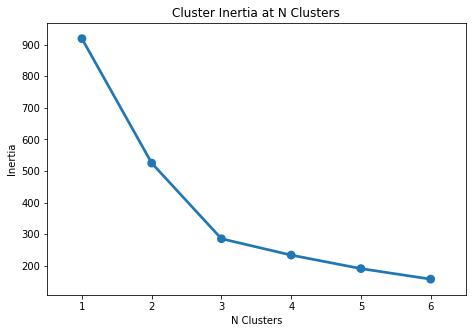

In [16]:
kms = km_intertia(master, np.arange(1, 7))

It looks like 3 clusters is the number we're looking for. We can use another heuristic, cluster silhouettes, to examine cluster overlap. This is calculated for individual data points in each cluster. Values closer to 1 indicate disjointedness from other clusters, while values closer to -1 represent homogeneity between clusters. The below function will visualize the silhouette score for the members of each cluster, and compare them to the average silhouette score for the entire dataset.

In [17]:
def silhouette_plots(df, cluster_counts, feat_names):
    for n_clusters in cluster_counts:
        fig, ax = plt.subplots()
        fig.set_size_inches(10, 7)
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax.set_xlim([-0.2, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax.set_ylim([0, len(df[feat_names]) + (n_clusters + 1) * 10])
        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        cluster_labels = kms['{0} clusters'.format(n_clusters)]
        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(df[feat_names], cluster_labels)
        print('At {0} clusters the mean silhouette score is {1}'.format(n_clusters, round(silhouette_avg, 4)))
        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(df[feat_names], cluster_labels)
        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i
            color = cm.spectral(float(i) / n_clusters)
            ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
            # Label the silhouette plots with their cluster numbers at the middle
            ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples
        ax.set_xlabel('The silhouette coefficient values')
        ax.set_ylabel('Cluster label')
        # The vertical line for average silhouette score of all the values
        ax.axvline(x=silhouette_avg, color='red', linestyle='--')
        ax.set_yticks([])  # Clear the yaxis labels / ticks
        ax.set_xticks([-0.2, -0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.title('Silhouette analysis for {0} clusters'.format(n_clusters))
        plt.show()

At 2 clusters the mean silhouette score is 0.41


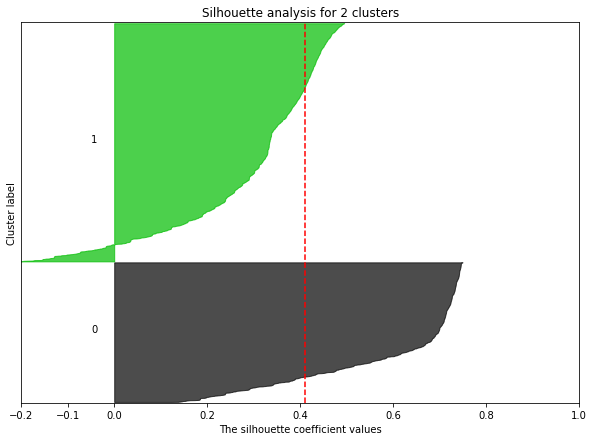

At 3 clusters the mean silhouette score is 0.5074


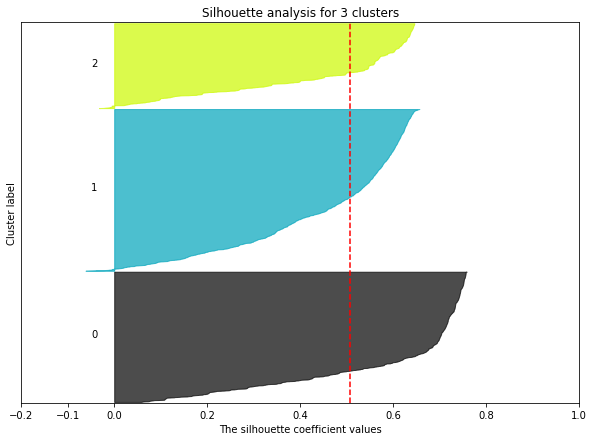

At 4 clusters the mean silhouette score is 0.4899


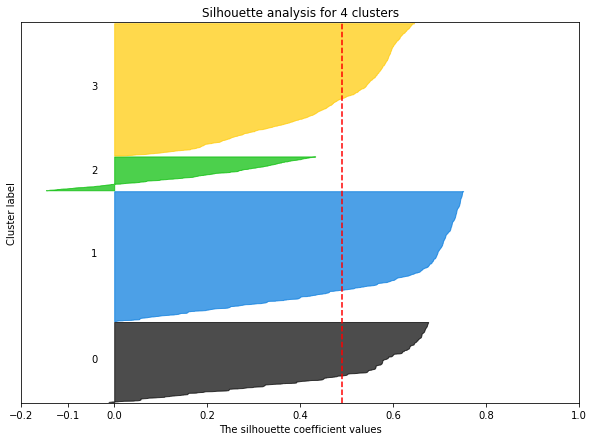

In [18]:
silhouette_plots(kms, [2, 3, 4], master.columns)        

We can see that 3 clusters is the way to go. 2 clusters appears to be too general, with some spilling between groups, and 4 clusters appears to just be nitpicking, with one less signficant sub-population included. At 3 clusters, we have nicely rounded knives with minimal with negative silhouette values.

# Examining our clusters
Now that we've discovered 3 distinct populations among our entire customer base, we can examine what makes each cluster unique.

In [19]:
def compare_clusters(df, cluster_var):
    temp = df.copy()
    temp['Cluster'] = cluster_var
    temp_stats = temp.groupby('Cluster', as_index=False).mean()
    temp_count = temp.groupby('Cluster', as_index=False).count()[['Cluster', 'MeanTransactionNetValue']]
    temp_count.rename({'MeanTransactionNetValue': 'Count'}, axis=1, inplace=True)
    feats = df.columns.tolist()
    plt.figure(figsize=(20, 7.5*math.ceil(len(feats)/2)))
    plt.subplot(math.ceil((len(feats) + 1)/2), 2, 1)
    plt.title('Cluster Sizes')
    plt.grid()
    sns.barplot(x='Cluster', y='Count', data=temp_count, errwidth=0)
    for i, var in enumerate(feats):
        plt.subplot(math.ceil((len(feats) + 1)/2), 2, i+2)
        plt.title('Cluster Mean, {0}'.format(var))
        plt.grid()
        sns.barplot(x='Cluster', y=var, data=temp, errwidth=0)

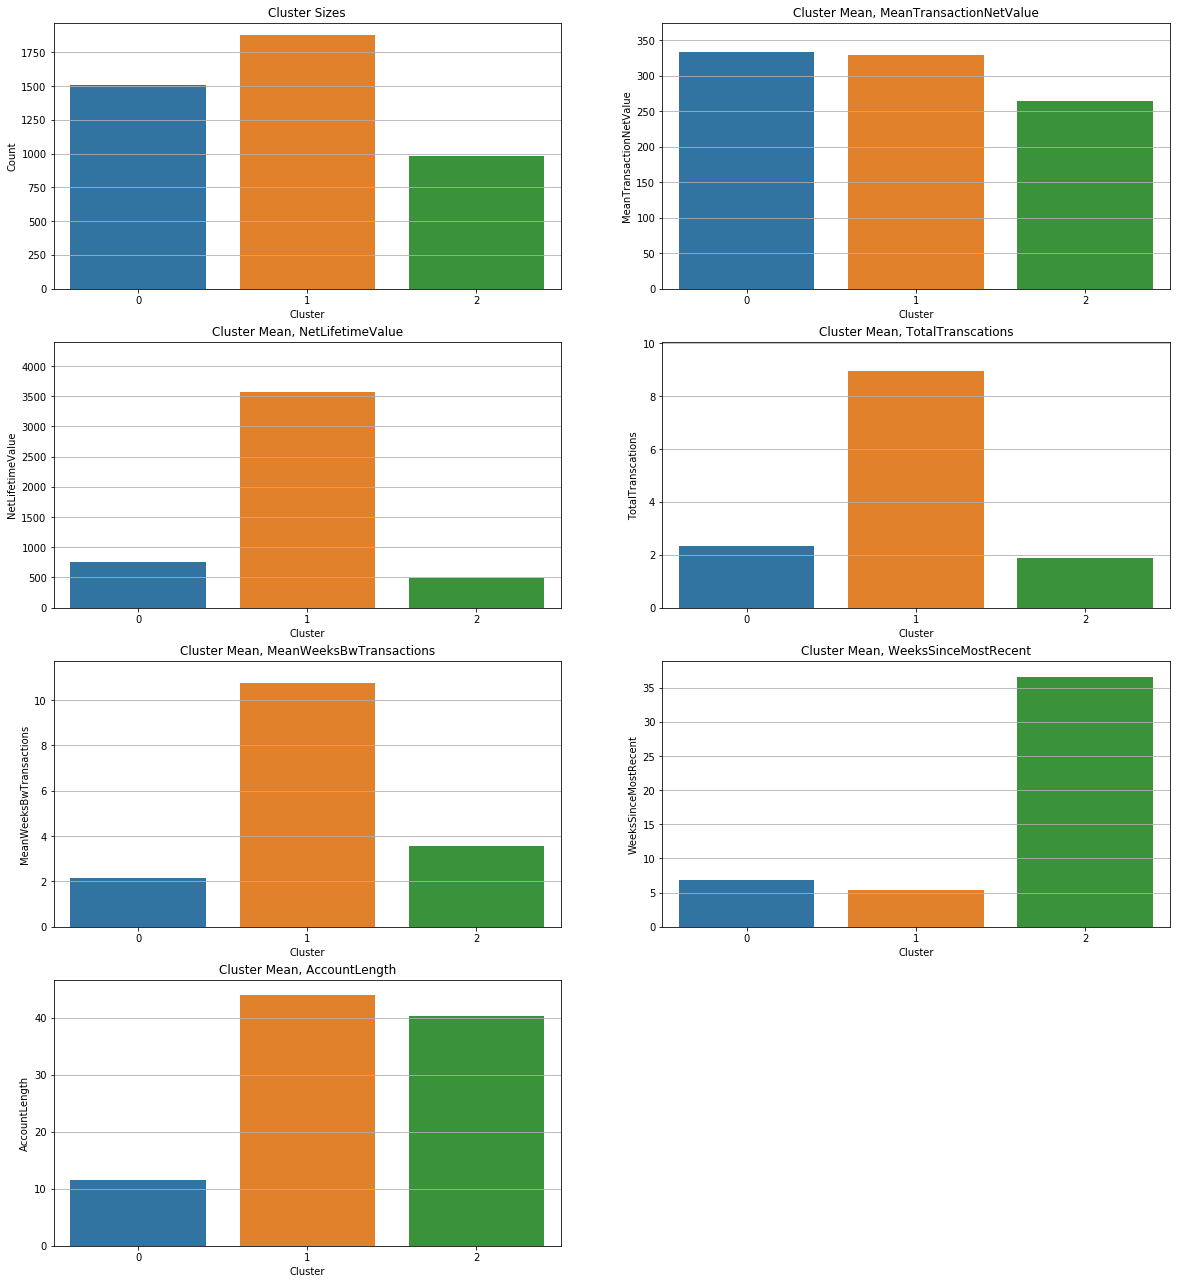

In [20]:
compare_clusters(master_original, kms['3 clusters'])

Categorizing our clusters:

## Cluster 0: *Consistent and Loyal*

This your cash cow segment. This group represents 42.9% of all customers in our dataset, the largest of all 3 clusters. Customers in this population generate the most revenue, higher than both other clusters. They are also the most recent customers, with their average time since last transaction being 5 weeks. The one unexpected metric in which they lead is average time between transactions, about 10 weeks, considerably higher than the other populations. However, their relationships with the company have lasted the longest, and they have the greatest mean lifetime value by far. Their relative infrequency is offset by their consistency. 
    


## Cluster 1: *Limited Present Value *
    
This group represents 22.5% of all customers in our dataset. Of all 3 clusters, customers in this group have the lowest mean lifetime value and the greatest mean time since their last transaction, all while being long-time customers. Despite their lengthy relationships with the company, they are responsible for the fewest average  transactions on a per customer basis. These accounts probably have a greater share of wallet to be won, and deserve some renewed attention from the sales team.
    
    
    
## Cluster 2: *New Potential*

This group represents 34.6% of all customers in our dataset. As a population, these customers have low average lifetime value, but a short history with the company, and as a group they have a strong showing of recent transaction activity. I categorize this group as promising young relationships that have the potential to mature into high value accounts.


I'm also curious to see if our clusters are represented differently internationally. Most of our customers are UK-based, so we'll create a binary "domestic" variable for our customers.

In [21]:
temp_df = df.drop_duplicates('CustomerID').set_index('CustomerID').sort_index()
temp_df['Domestic'] = temp_df['Country'].where(temp_df['Country'] == 'United Kingdom', 'International')
temp_df['Domestic'] = temp_df['Domestic'].where(temp_df['Domestic'] == 'International', 'Domestic')
master = pd.concat([master_original, kms['3 clusters'], temp_df['Domestic']], axis=1)
master.rename({'3 clusters': 'Cluster'}, axis=1, inplace=True)

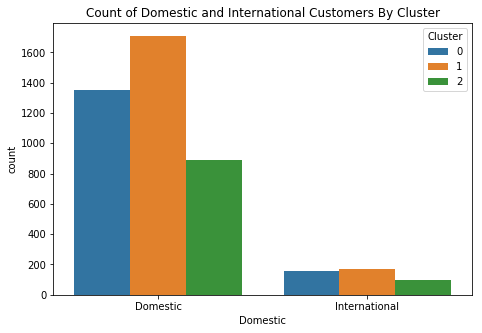

In [22]:
plt.figure(figsize=(7.5, 5))
plt.title('Count of Domestic and International Customers By Cluster')
sns.countplot(data=master, x='Domestic', hue='Cluster')

We don't have an obvious pattern here. The low-value segment is slightly more represented among international customers than the other segments, but it isn't particularly substantial.

The last task remaining is to train a classifier in order to predict which of our 3 segments other customers of ours may belong to.

# Classification

Gradient boosting is a tried and true off the shelf classification algorithm, and should have no problem with a dataset of this size and complexity. We'll split our dataset into training and testing sets and fit a classifier.

In [23]:
def classif_report(true_results, predicted_results):
    print('Classifcation Report:\n')
    print(classification_report(true_results, predicted_results))
    print('\nConfusion Matrix:\n')
    print(pd.DataFrame(data=confusion_matrix(true_results, predicted_results), columns=['Predicted 0', 'Predicted 1', 'Predicted 2'], index=['Actual 0', 'Actual 1', 'Actual 2']))

In [24]:
X, X_holdout, y, y_holdout = train_test_split(master.drop(['Cluster', 'Domestic'], axis=1), master['Cluster'], test_size=0.25, random_state=10)
train = pd.concat([X, y], axis=1)

In [25]:
gb = GradientBoostingClassifier(random_state=10).fit(MaxAbsScaler().fit_transform(X), y)
classif_report(cross_val_predict(gb, MaxAbsScaler().fit_transform(X), y, cv=5), y)

Classifcation Report:

             precision    recall  f1-score   support

          0       1.00      1.00      1.00      1123
          1       0.99      0.99      0.99      1405
          2       0.99      0.99      0.99       751

avg / total       0.99      0.99      0.99      3279


Confusion Matrix:

          Predicted 0  Predicted 1  Predicted 2
Actual 0         1118            4            1
Actual 1            3         1395            7
Actual 2            0            4          747


Excellent performance making cross-validated predictions on the training data. Now we'll see how we fare with the testing data.

In [26]:
classif_report(gb.predict(MaxAbsScaler().fit_transform(X_holdout)), y_holdout)

Classifcation Report:

             precision    recall  f1-score   support

          0       1.00      1.00      1.00       390
          1       1.00      1.00      1.00       474
          2       1.00      1.00      1.00       229

avg / total       1.00      1.00      1.00      1093


Confusion Matrix:

          Predicted 0  Predicted 1  Predicted 2
Actual 0          389            1            0
Actual 1            1          472            1
Actual 2            0            0          229


Just about flawless. We've found our unique customer segments and have fitted a classifier to make accurate categorizations of other customers down the road.

# Conclusions
* Unsupervised learning was a big departure for me. It's certainly a very different procedure than what I've grown used to in my previous supervised learning projects.
* Perhaps just as important as working with different clustering techniques was learning different ways to manipulate the data. I worked with a number of different datasets of various sizes, from 500 to 3,000,000 observations, experimenting with different things. The practice with grouping, pivoting, joining, and aggregating data frames was a very valuable experience.
* I have no immediate plans for my next project. I'm eyeing something more sophisticated, like deep learning, but before that I'll need a break from portfolio projects to catch up on sleep. In the mean time, I'm helping put together a simple class project involving optimization algorithms, and R is the main focus of that class. It's about time I cut my teeth on a hands-on project using R.